<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/test/retinex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')

In [2]:
class DecomNet(tf.keras.Model):
    def __init__(self, layer_num=5,channel=64, kernel_size=3):
        super(DecomNet, self).__init__()
        self.layer_num=layer_num
        self.channel=channel
        self.kernel_size=kernel_size
        self.conv1 = tf.keras.layers.Conv2D(channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        self.out= tf.keras.layers.Conv2D(4, kernel_size, padding='same', activation=None, name='recon_layer')
  
        
    def call(self,input_tensor):
      x=tf.math.reduce_max(input_tensor,axis=3,keepdims=True)
      x=tf.keras.layers.concatenate([input_tensor,x])
      conv=self.conv1(x)
      #conv=self.seq(conv)
      for idx in range(self.layer_num):
            conv= tf.keras.layers.Conv2D(self.channel, self.kernel_size, padding='same', activation=tf.nn.relu, name='activated_layer_%d' % idx)(conv)
      conv=self.out(conv)
      R = tf.keras.activations.sigmoid(conv[:,:,:,0:3],name="Reflectance")
      L = tf.keras.activations.sigmoid(conv[:,:,:,3:4],name="Illuminance")
      return R,L

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
    def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
tf.math.reduce_max (TFOpLambda) (None, 412, 548, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 412, 548, 4)  0           input_1[0][0]                    
                                                                 tf.math.reduce_max[0][0]         
__________________________________________________________________________________________________
shallow_feature_extraction (Con (None, 412, 548, 64) 20800       concatenate[0][0]            

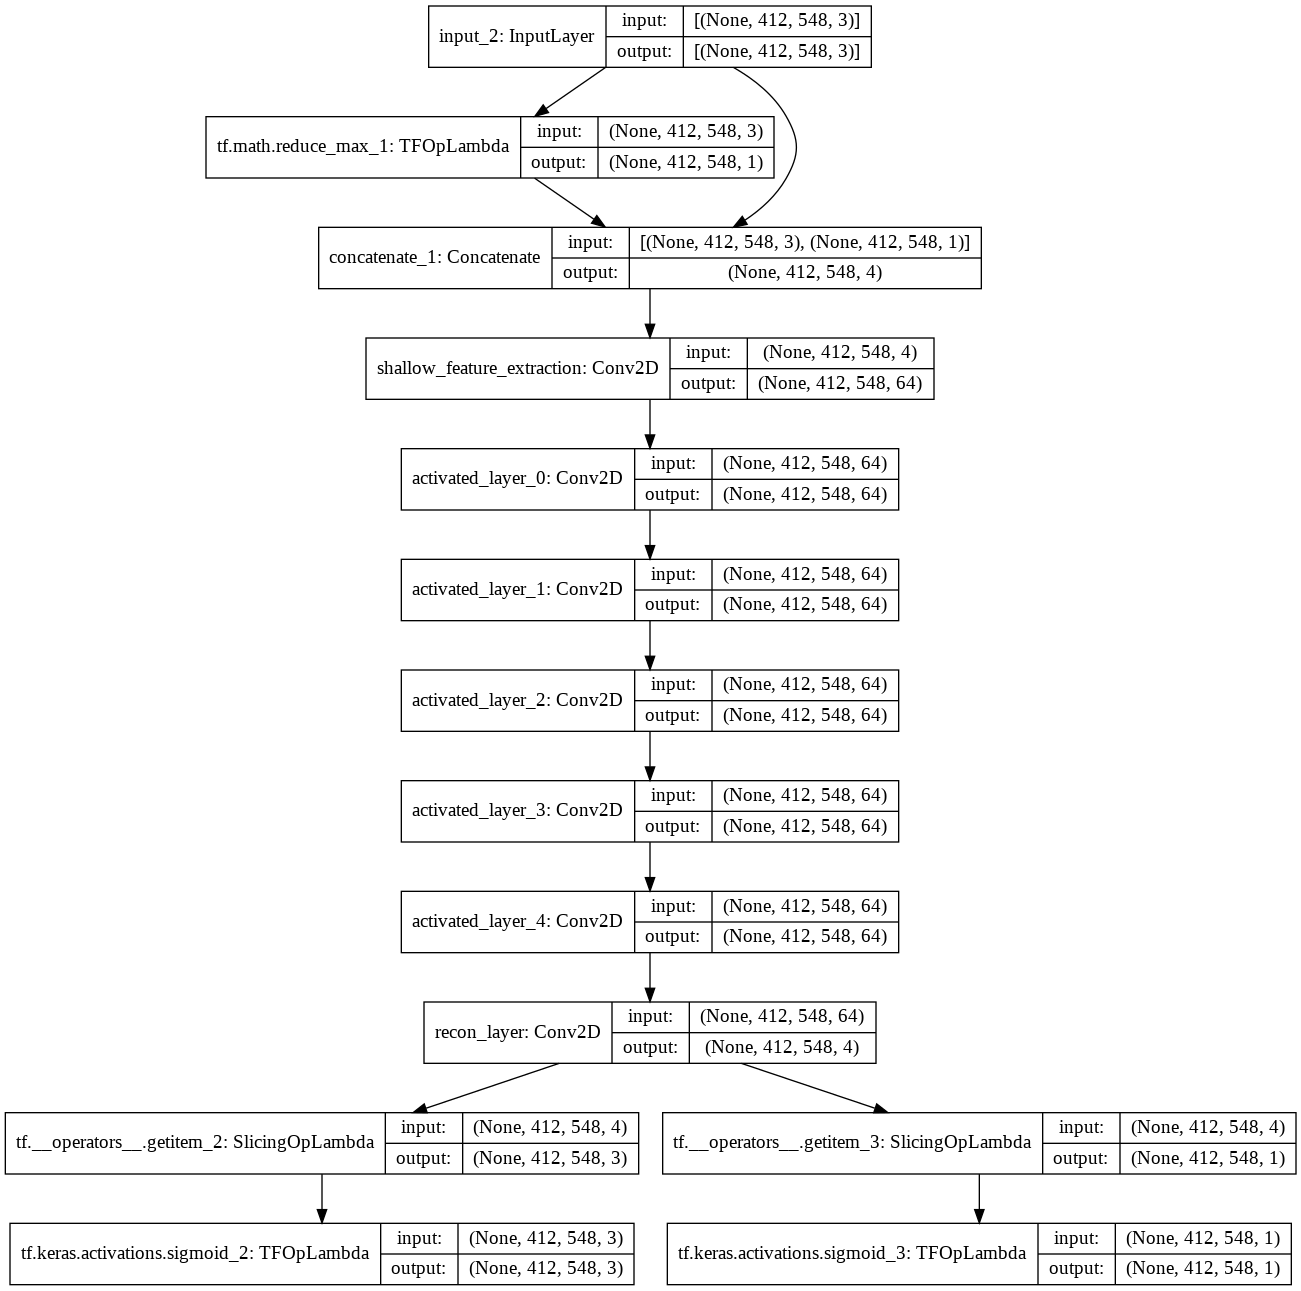

In [3]:


sub = DecomNet()
sub.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    sub.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)



In [50]:
class RelightNet(tf.keras.Model):
  def __init__(self,channel=64, kernel_size=3):
    super(RelightNet, self).__init__()
    self.channel=channel
    self.kernel_size=kernel_size

  def call(self,input_L,input_R):
    
    
    input_im =tf.keras.layers.concatenate([input_R,input_L])

    conv0 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, padding='same', activation=None,input_shape=input_im.shape)(input_im)
    conv1 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, strides=2, padding='same', activation=tf.nn.relu,input_shape=conv0.shape)(conv0)
    conv2 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, strides=2, padding='same', activation=tf.nn.relu,input_shape=conv1.shape)(conv1)
    conv3 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, strides=2, padding='same', activation=tf.nn.relu,input_shape=conv2.shape)(conv2)
    
    up1 =tf.keras.layers.experimental.preprocessing.Resizing(conv2.shape[1],conv2.shape[2],interpolation='nearest')(conv3)
    deconv1 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, padding='same', activation=tf.nn.relu,name="deconv1")(up1) + conv2
    
    up2 =tf.keras.layers.experimental.preprocessing.Resizing(conv1.shape[1],conv1.shape[2],interpolation='nearest')(deconv1)
    deconv2 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, padding='same', activation=tf.nn.relu,name="deconv2")(up2) + conv1
    up3 =tf.keras.layers.experimental.preprocessing.Resizing(conv0.shape[1],conv0.shape[2],interpolation='nearest')(deconv2)
    deconv3 = tf.keras.layers.Conv2D(self.channel, self.kernel_size, padding='same', activation=tf.nn.relu,name="deconv3")(up3) + conv0
    deconv1_resize = tf.keras.layers.experimental.preprocessing.Resizing(deconv3.shape[1],deconv3.shape[2],interpolation='nearest')(deconv1)
    deconv2_resize = tf.keras.layers.experimental.preprocessing.Resizing(deconv3.shape[1],deconv3.shape[2],interpolation='nearest')(deconv2)
    feature_gather = tf.keras.layers.concatenate([deconv1_resize, deconv2_resize, deconv3])
    feature_fusion = tf.keras.layers.Conv2D(self.channel, 1, padding='same', activation=None)(feature_gather)
    output = tf.keras.layers.Conv2D(1, 3, padding='same', activation=None)(feature_fusion)
    return output

  def model(self):
        R = Input(shape = (412, 548, 3))
        L= Input(shape = (412, 548, 1))
        
        return Model(inputs=[L,R], outputs=self.call(L,R))

    
  def build_graph(self):
        R = Input(shape = (412, 548, 3))
        L= Input(shape = (412, 548, 1))
        
        return Model(inputs=[L,R], outputs=self.call(L,R))


Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           [(None, 412, 548, 1) 0                                            
__________________________________________________________________________________________________
concatenate_45 (Concatenate)    (None, 412, 548, 4)  0           input_83[0][0]                   
                                                                 input_84[0][0]                   
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 412, 548, 64) 2368        concatenate_45[0][0]      

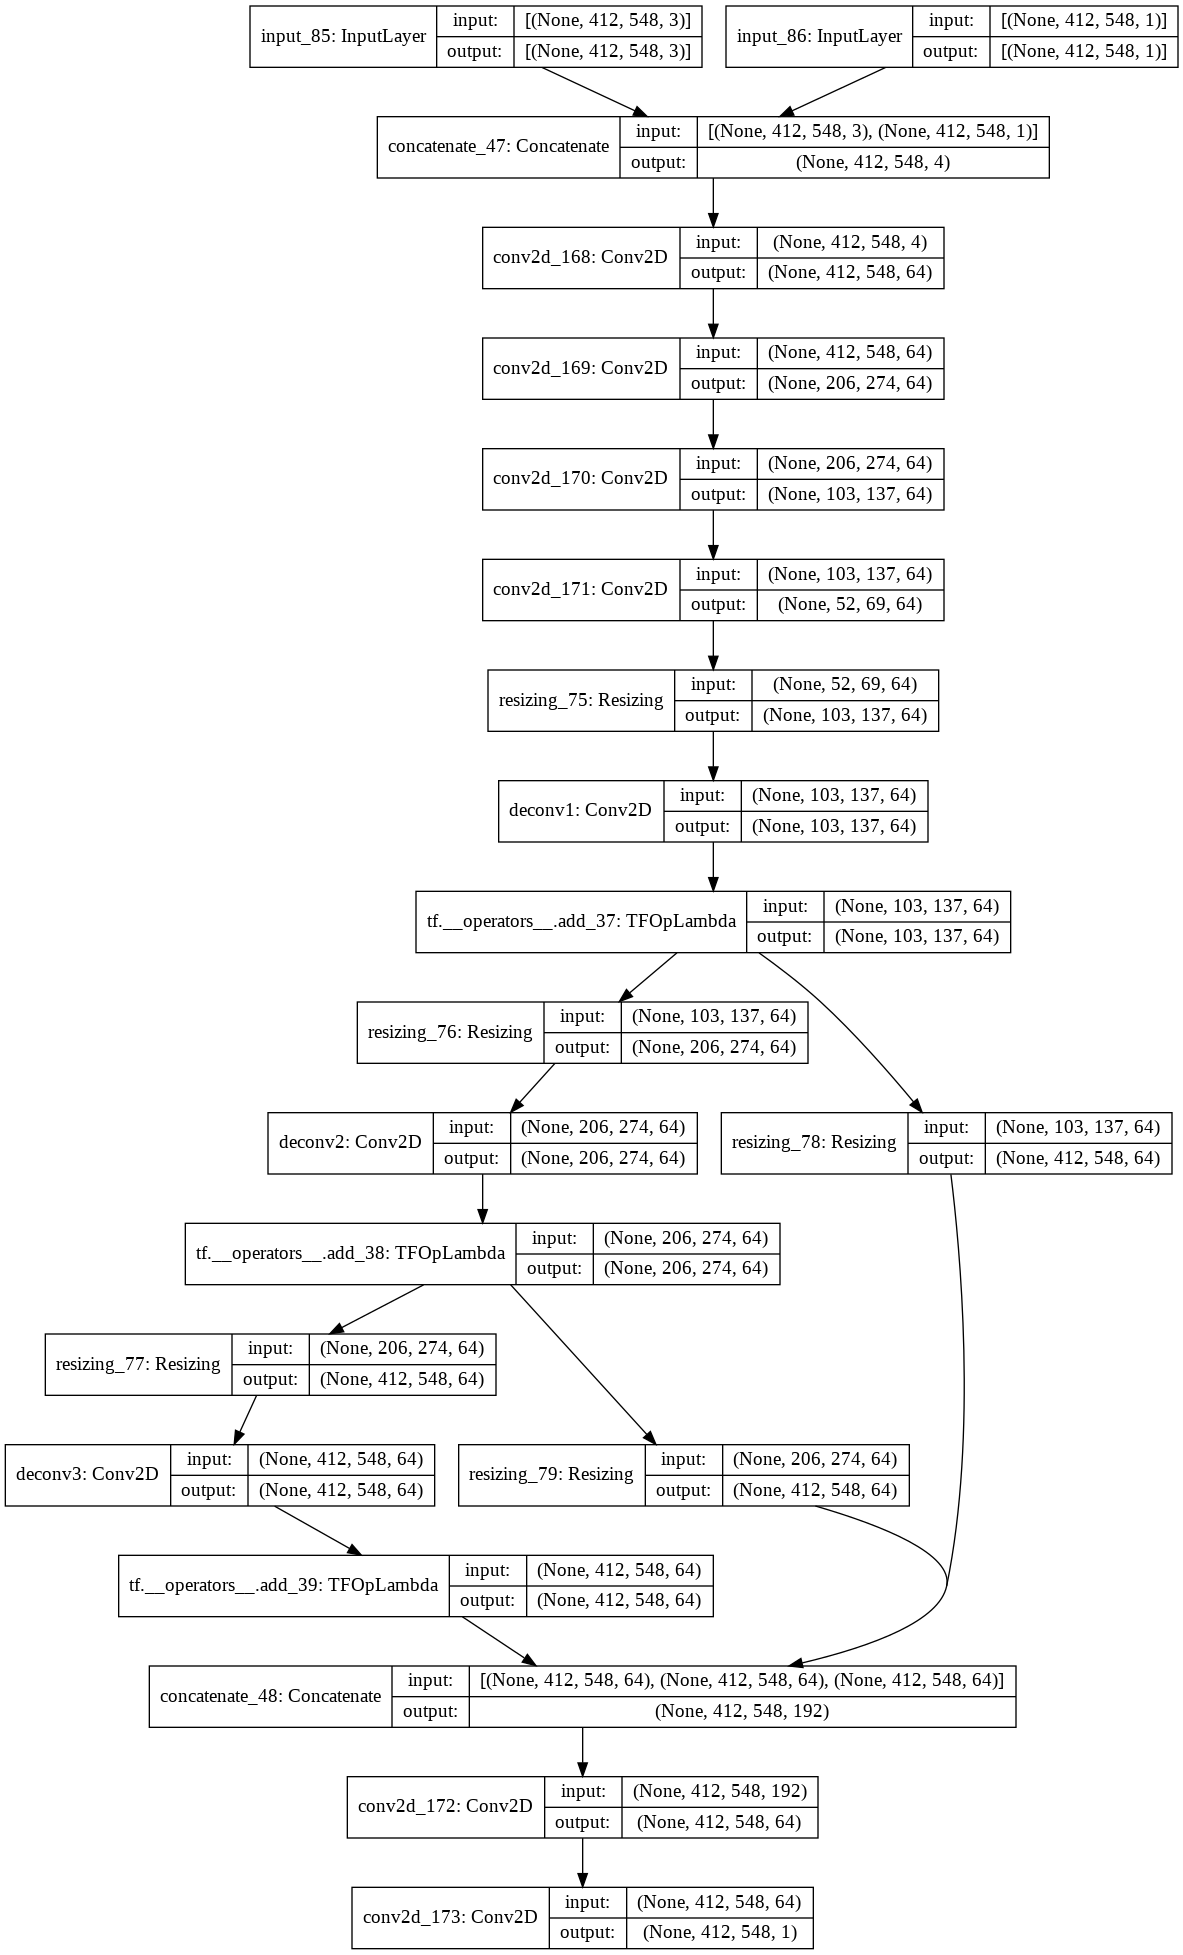

In [51]:
sub = RelightNet()
sub.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    sub.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [53]:
class lowlight_enhance(tf.keras.Model):
    def __init__(self):
        super(lowlight_enhance, self).__init__()
        self.DecomNet_layer_num = 5
        self.DecomNet=DecomNet(self.DecomNet_layer_num)
        
    def call(self,input_low,input_high):
        [R_low, I_low] = DecomNet(input_low)
        [R_high, I_high] = DecomNet(input_high)
        
        I_delta = RelightNet(I_low, R_low)

        I_low_3 = concat([I_low, I_low, I_low])
        I_high_3 = concat([I_high, I_high, I_high])
        I_delta_3 = concat([I_delta, I_delta, I_delta])

        self.output_R_low = R_low
        self.output_I_low = I_low_3
        self.output_I_delta = I_delta_3
        self.output_S = R_low * I_delta_3


In [ ]:
from __future__ import print_function

import os
import time
import random

from PIL import Image
import tensorflow as tf
import numpy as np

from utils import *

def concat(layers):
    return tf.concat(layers, axis=3)

def DecomNet(input_im, layer_num, channel=64, kernel_size=3):
    input_max = tf.reduce_max(input_im, axis=3, keepdims=True)
    input_im = concat([input_max, input_im])
    with tf.variable_scope('DecomNet', reuse=tf.AUTO_REUSE):
        conv = tf.layers.conv2d(input_im, channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        for idx in range(layer_num):
            conv = tf.layers.conv2d(conv, channel, kernel_size, padding='same', activation=tf.nn.relu, name='activated_layer_%d' % idx)
        conv = tf.layers.conv2d(conv, 4, kernel_size, padding='same', activation=None, name='recon_layer')

    R = tf.sigmoid(conv[:,:,:,0:3])
    L = tf.sigmoid(conv[:,:,:,3:4])

    return R, L

def RelightNet(input_L, input_R, channel=64, kernel_size=3):
    input_im = concat([input_R, input_L])
    with tf.variable_scope('RelightNet'):
        conv0 = tf.layers.conv2d(input_im, channel, kernel_size, padding='same', activation=None)
        conv1 = tf.layers.conv2d(conv0, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv2, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        
        up1 = tf.image.resize_nearest_neighbor(conv3, (tf.shape(conv2)[1], tf.shape(conv2)[2]))
        deconv1 = tf.layers.conv2d(up1, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv2
        up2 = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(conv1)[1], tf.shape(conv1)[2]))
        deconv2= tf.layers.conv2d(up2, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv1
        up3 = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(conv0)[1], tf.shape(conv0)[2]))
        deconv3 = tf.layers.conv2d(up3, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv0
        
        deconv1_resize = tf.image.resize_nearest_neighbor(deconv1, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        deconv2_resize = tf.image.resize_nearest_neighbor(deconv2, (tf.shape(deconv3)[1], tf.shape(deconv3)[2]))
        feature_gather = concat([deconv1_resize, deconv2_resize, deconv3])
        feature_fusion = tf.layers.conv2d(feature_gather, channel, 1, padding='same', activation=None)
        output = tf.layers.conv2d(feature_fusion, 1, 3, padding='same', activation=None)
    return output

class lowlight_enhance(object):
    def __init__(self, sess):
        self.sess = sess
        self.DecomNet_layer_num = 5

        # build the model
        self.input_low = tf.placeholder(tf.float32, [None, None, None, 3], name='input_low')
        self.input_high = tf.placeholder(tf.float32, [None, None, None, 3], name='input_high')

        [R_low, I_low] = DecomNet(self.input_low, layer_num=self.DecomNet_layer_num)
        [R_high, I_high] = DecomNet(self.input_high, layer_num=self.DecomNet_layer_num)
        
        I_delta = RelightNet(I_low, R_low)

        I_low_3 = concat([I_low, I_low, I_low])
        I_high_3 = concat([I_high, I_high, I_high])
        I_delta_3 = concat([I_delta, I_delta, I_delta])

        self.output_R_low = R_low
        self.output_I_low = I_low_3
        self.output_I_delta = I_delta_3
        self.output_S = R_low * I_delta_3

        # loss
        self.recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  self.input_low))
        self.recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - self.input_high))
        self.recon_loss_mutal_low = tf.reduce_mean(tf.abs(R_high * I_low_3 - self.input_low))
        self.recon_loss_mutal_high = tf.reduce_mean(tf.abs(R_low * I_high_3 - self.input_high))
        self.equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))
        self.relight_loss = tf.reduce_mean(tf.abs(R_low * I_delta_3 - self.input_high))

        self.Ismooth_loss_low = self.smooth(I_low, R_low)
        self.Ismooth_loss_high = self.smooth(I_high, R_high)
        self.Ismooth_loss_delta = self.smooth(I_delta, R_low)

        self.loss_Decom = self.recon_loss_low + self.recon_loss_high + 0.001 * self.recon_loss_mutal_low + 0.001 * self.recon_loss_mutal_high + 0.1 * self.Ismooth_loss_low + 0.1 * self.Ismooth_loss_high + 0.01 * self.equal_R_loss
        self.loss_Relight = self.relight_loss + 3 * self.Ismooth_loss_delta

        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        optimizer = tf.train.AdamOptimizer(self.lr, name='AdamOptimizer')

        self.var_Decom = [var for var in tf.trainable_variables() if 'DecomNet' in var.name]
        self.var_Relight = [var for var in tf.trainable_variables() if 'RelightNet' in var.name]

        self.train_op_Decom = optimizer.minimize(self.loss_Decom, var_list = self.var_Decom)
        self.train_op_Relight = optimizer.minimize(self.loss_Relight, var_list = self.var_Relight)

        self.sess.run(tf.global_variables_initializer())

        self.saver_Decom = tf.train.Saver(var_list = self.var_Decom)
        self.saver_Relight = tf.train.Saver(var_list = self.var_Relight)

        print("[*] Initialize model successfully...")

    def gradient(self, input_tensor, direction):
        self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
        self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

        if direction == "x":
            kernel = self.smooth_kernel_x
        elif direction == "y":
            kernel = self.smooth_kernel_y
        return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))

    def ave_gradient(self, input_tensor, direction):
        return tf.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

    def smooth(self, input_I, input_R):
        input_R = tf.image.rgb_to_grayscale(input_R)
        return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

    

    

In [ ]:

with tf.Session() as sess:
    model = lowlight_enhance(sess)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
[*] Initialize model successfully...


In [ ]:

model.build([413,550,3])
model.summary()


AttributeError: ignored